Image Deconvolution Parameter Tuning
====================================

This example demonstrates the use of
[scico.ray.tune](../_autosummary/scico.ray.tune.rst) to tune parameters
for the companion [example script](deconv_tv_admm.rst).

In [1]:
import numpy as np

import jax

from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
import scico.ray as ray
from scico import functional, linop, loss, metric, plot
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.ray import tune
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
phantom = SiemensStar(32)
N = 256  # image size
x_gt = snp.pad(discrete_phantom(phantom, N - 16), 8)

Set up the forward operator and create a test signal consisting of a
blurred signal with additive Gaussian noise.

In [3]:
n = 5  # convolution kernel size
σ = 20.0 / 255  # noise level

psf = snp.ones((n, n)) / (n * n)
A = linop.Convolve(h=psf, input_shape=x_gt.shape)

Ax = A(x_gt)  # blurred image
noise, key = scico.random.randn(Ax.shape, seed=0)
y = Ax + σ * noise

Put main arrays into ray object store.

In [4]:
ray_x_gt, ray_psf, ray_y = ray.put(np.array(x_gt)), ray.put(np.array(psf)), ray.put(np.array(y))

Define performance evaluation function.

In [5]:
def eval_params(config, reporter):
    # Extract solver parameters from config dict.
    λ, ρ = config["lambda"], config["rho"]
    # Get main arrays from ray object store.
    x_gt, psf, y = ray.get([ray_x_gt, ray_psf, ray_y])
    # Put main arrays on jax device.
    x_gt, psf, y = jax.device_put([x_gt, psf, y])
    # Set up problem to be solved.
    A = linop.Convolve(h=psf, input_shape=x_gt.shape)
    f = loss.SquaredL2Loss(y=y, A=A)
    g = λ * functional.L21Norm()
    C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
    # Define solver.
    solver = ADMM(
        f=f,
        g_list=[g],
        C_list=[C],
        rho_list=[ρ],
        x0=A.adj(y),
        maxiter=10,
        subproblem_solver=LinearSubproblemSolver(),
    )
    # Perform 50 iterations, reporting performance to ray.tune every 10 iterations.
    for step in range(5):
        x_admm = solver.solve()
        reporter(psnr=float(metric.psnr(x_gt, x_admm)))

Define parameter search space and resources per trial.

In [6]:
config = {"lambda": tune.loguniform(1e-2, 1e0), "rho": tune.loguniform(1e-1, 1e1)}
resources = {"cpu": 4, "gpu": 0}  # cpus per trial, gpus per trial

Run parameter search.

In [7]:
analysis = tune.run(
    eval_params,
    metric="psnr",
    mode="max",
    num_samples=100,
    config=config,
    resources_per_trial=resources,
    hyperopt=True,
    verbose=True,
)

(pid=76564) 2022-05-19 09:51:58.428566: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=76564) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(pid=76588) 2022-05-19 09:51:59.302661: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=76588) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(pid=76613) 2022-05-19 09:52:00.992721: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=76613) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(pid=76912) 2022-05-19 09:52:01.875511: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=76912) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(pid=77253) 2022-05-19 09:52:03.269406: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=77253) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(pid=77573) 2022-05-19 09:52:04.623654: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=77573) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(pid=77913) 2022-05-19 09:52:05.738215: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=77913) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(pid=78268) 2022-05-19 09:52:07.129536: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=78268) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(pid=78263) 2022-05-19 09:52:07.224076: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=78263) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(pid=78646) 2022-05-19 09:52:08.718659: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=78646) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(pid=79089) 2022-05-19 09:52:10.217716: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=79089) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(pid=79071) 2022-05-19 09:52:10.325474: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=79071) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(pid=79073) 2022-05-19 09:52:10.620477: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=79073) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(pid=79072) 2022-05-19 09:52:10.736340: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=79072) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(pid=79934) 2022-05-19 09:52:12.503252: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=79934) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(pid=80287) 2022-05-19 09:52:14.105686: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=80287) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(pid=80298) 2022-05-19 09:52:14.364562: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=80298) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(pid=80286) 2022-05-19 09:52:14.845271: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=80286) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(pid=81617) 2022-05-19 09:52:16.558054: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=81617) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(pid=81616) 2022-05-19 09:52:16.767658: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=81616) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


P:   0 R:   0 T: 100  psnr: 2.34e+01 at lambda: 2.69e-02, rho: 1.24e-01


2022-05-19 09:52:32,037	INFO tune.py:617 -- Total run time: 37.09 seconds (36.45 seconds for the tuning loop).


Display best parameters and corresponding performance.

In [8]:
best_config = analysis.get_best_config(metric="psnr", mode="max")
print(f"Best PSNR: {analysis.get_best_trial().last_result['psnr']:.2f} dB")
print("Best config: " + ", ".join([f"{k}: {v:.2e}" for k, v in best_config.items()]))

Best PSNR: 23.41 dB
Best config: lambda: 2.69e-02, rho: 1.24e-01


Plot parameter values visited during parameter search. Marker sizes are
proportional to number of iterations run at each parameter pair. The best
point in the parameter space is indicated in red.

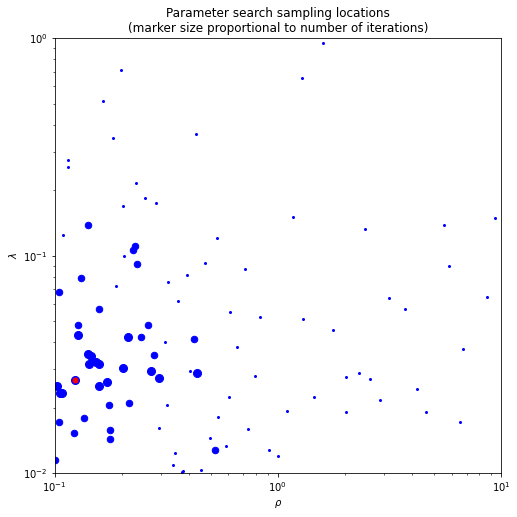

In [9]:
fig = plot.figure(figsize=(8, 8))
for t in analysis.trials:
    n = t.metric_analysis["training_iteration"]["max"]
    plot.plot(
        t.config["lambda"],
        t.config["rho"],
        ptyp="loglog",
        lw=0,
        ms=(0.5 + 1.5 * n),
        marker="o",
        mfc="blue",
        mec="blue",
        fig=fig,
    )
plot.plot(
    best_config["lambda"],
    best_config["rho"],
    ptyp="loglog",
    title="Parameter search sampling locations\n(marker size proportional to number of iterations)",
    xlbl=r"$\rho$",
    ylbl=r"$\lambda$",
    lw=0,
    ms=5.0,
    marker="o",
    mfc="red",
    mec="red",
    fig=fig,
)
ax = fig.axes[0]
ax.set_xlim([config["rho"].lower, config["rho"].upper])
ax.set_ylim([config["lambda"].lower, config["lambda"].upper])
fig.show()